In [1]:
import sys
sys.path.insert(1, '../')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error

from agingml import temporal_degradation_test as tdt

/Users/santiago/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_results():
    for model in models:
        errors_df = pd.read_parquet(f'../results/aging/{dataset}/aging_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod.parquet')
        d_errors_df = pd.read_parquet(f'../results/aging/{dataset}/aging_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod_{freq}.parquet')
        
        errors_df = errors_df[errors_df['model_age'] <= 80]
        d_errors_df = d_errors_df[d_errors_df['model_age'] <= 80]
        test_errors_df = errors_df[errors_df['partition'] == 'test']
        test_mape = test_errors_df.groupby('simulation_id').apply(lambda group: mean_absolute_percentage_error(group.y, group.y_pred))
        test_mape = pd.DataFrame(test_mape, columns=['test_mape']).reset_index()

        d_errors_df = pd.merge(d_errors_df, test_mape, how='left', on='simulation_id')
        d_errors_df = d_errors_df[d_errors_df['test_mape'] <= 0.1]

        valid_models = len(d_errors_df['simulation_id'].drop_duplicates())
        print(f'There are {valid_models} out of {n_simulations}')

        d_errors_df['degradation'] = d_errors_df['error'] > 0.15
        degradations_per_model = d_errors_df.groupby(['simulation_id'])[['degradation']].sum().reset_index()
        num_degradated_models = len(degradations_per_model[degradations_per_model['degradation'] > 5])

        print(f"{num_degradated_models} out of {len(degradations_per_model)} models ({np.round(100 * num_degradated_models / len(degradations_per_model), 1)} %) degradaded")

        print(degradations_per_model.degradation.sort_values())
        fig = tdt.plot_aging_chart(d_errors_df, metric='MAPE', freq='weeks', plot_name=f"Model Aging Chart: US Avocado Hass Dataset - {model}")
        fig.show()
        fig.savefig(f'../figures/aging/avocados/aging_plot_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod.svg', format='svg')

There are 884 out of 1000
812 out of 884 models (91.9 %) degradaded
777     0
148     0
578     0
73      1
163     1
       ..
417    38
883    38
124    41
326    42
446    42
Name: degradation, Length: 884, dtype: int64


/var/folders/yn/9gj_99ys1mz0_tkl2kvh5wd40000gn/T/ipykernel_9854/3463322363.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


There are 842 out of 1000
842 out of 842 models (100.0 %) degradaded
681     7
658     7
463     8
690     9
821     9
       ..
369    41
229    41
349    41
78     41
466    43
Name: degradation, Length: 842, dtype: int64


/var/folders/yn/9gj_99ys1mz0_tkl2kvh5wd40000gn/T/ipykernel_9854/3463322363.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


There are 860 out of 1000
737 out of 860 models (85.7 %) degradaded
10      0
760     0
803     0
607     1
166     1
       ..
792    34
187    35
122    38
190    41
457    46
Name: degradation, Length: 860, dtype: int64


/var/folders/yn/9gj_99ys1mz0_tkl2kvh5wd40000gn/T/ipykernel_9854/3463322363.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


There are 625 out of 1000
615 out of 625 models (98.4 %) degradaded
608     2
125     4
119     4
287     4
243     5
       ..
58     47
104    48
94     54
372    58
435    59
Name: degradation, Length: 625, dtype: int64


/var/folders/yn/9gj_99ys1mz0_tkl2kvh5wd40000gn/T/ipykernel_9854/3463322363.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


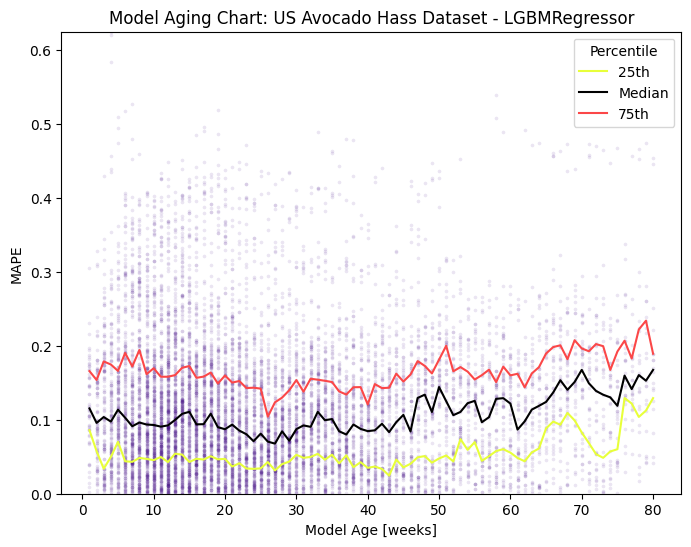

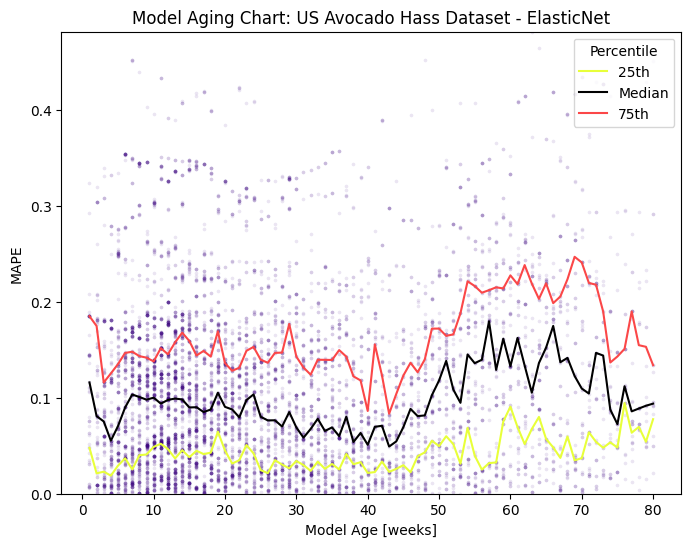

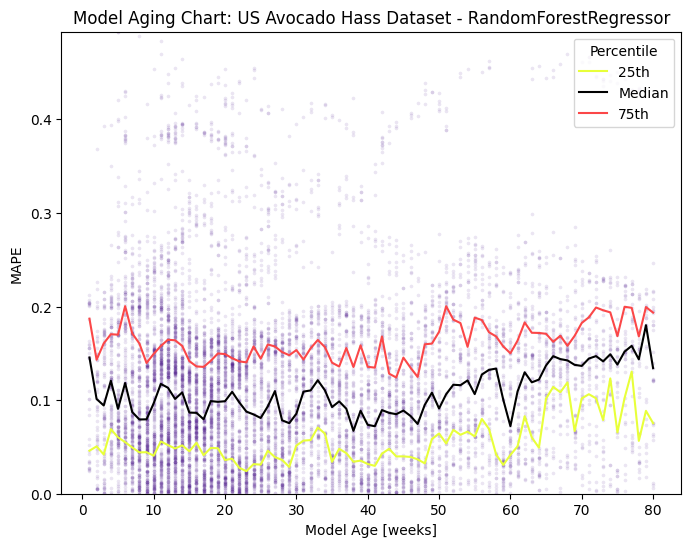

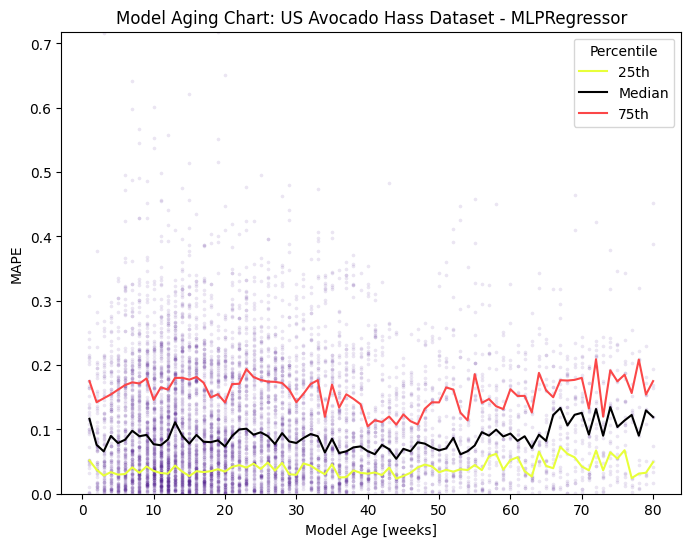

In [3]:
n_simulations = 1000
n_prod = 12
dataset = 'avocados'
freq='W'
models =['LGBMRegressor', 'ElasticNet', 'RandomForestRegressor', 'MLPRegressor']
plot_results()

There are 2684 out of 3000
2453 out of 2684 models (91.4 %) degradaded
895      1
536      1
1556     1
1043     1
580      1
        ..
906     36
69      36
2205    36
526     37
447     38
Name: degradation, Length: 2684, dtype: int64


/var/folders/yn/9gj_99ys1mz0_tkl2kvh5wd40000gn/T/ipykernel_9854/3463322363.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


There are 2423 out of 3000
2423 out of 2423 models (100.0 %) degradaded
121      9
684      9
1172     9
2110     9
102      9
        ..
829     41
1824    41
1283    41
9       41
313     41
Name: degradation, Length: 2423, dtype: int64


/var/folders/yn/9gj_99ys1mz0_tkl2kvh5wd40000gn/T/ipykernel_9854/3463322363.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


There are 2675 out of 3000
2492 out of 2675 models (93.2 %) degradaded
1180     1
2051     2
844      2
2064     2
2189     3
        ..
165     37
2254    39
644     39
2553    39
2022    41
Name: degradation, Length: 2675, dtype: int64


/var/folders/yn/9gj_99ys1mz0_tkl2kvh5wd40000gn/T/ipykernel_9854/3463322363.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


There are 2045 out of 3000
2032 out of 2045 models (99.4 %) degradaded
1936     4
172      4
1739     4
652      4
265      4
        ..
1463    57
1749    60
527     62
1848    63
678     66
Name: degradation, Length: 2045, dtype: int64


/var/folders/yn/9gj_99ys1mz0_tkl2kvh5wd40000gn/T/ipykernel_9854/3463322363.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


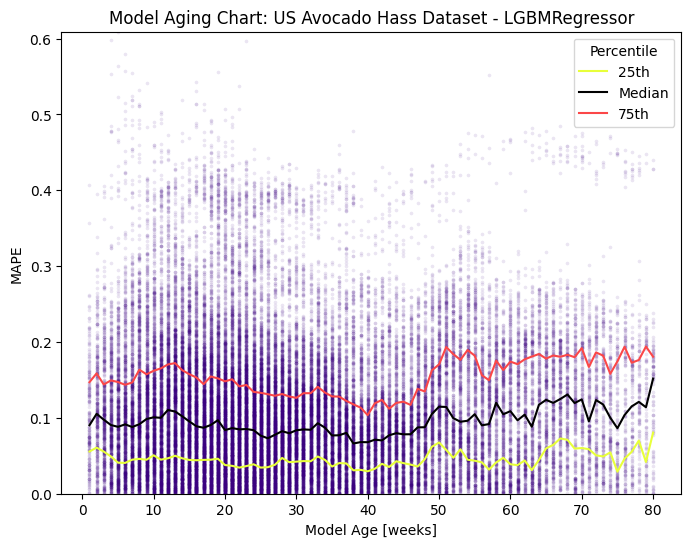

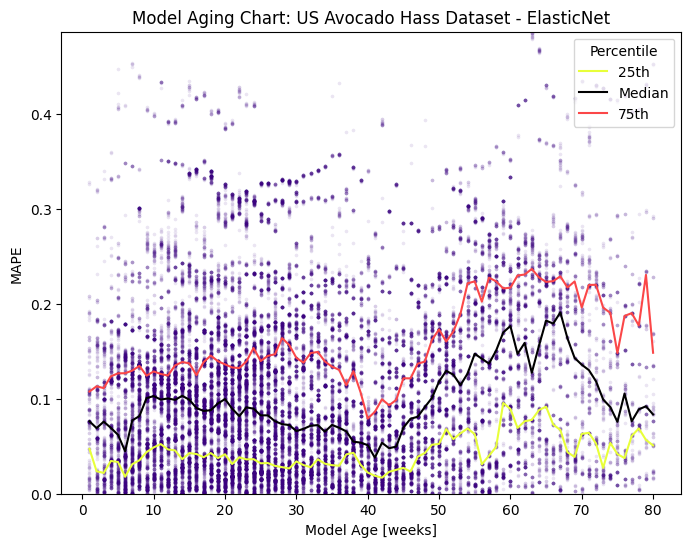

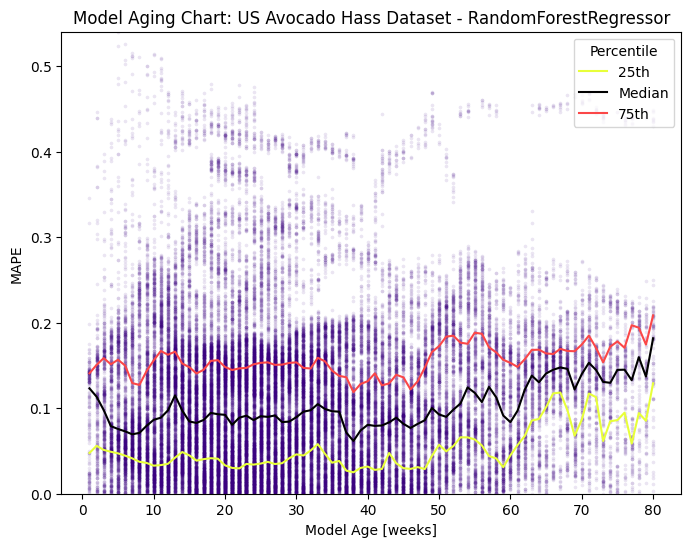

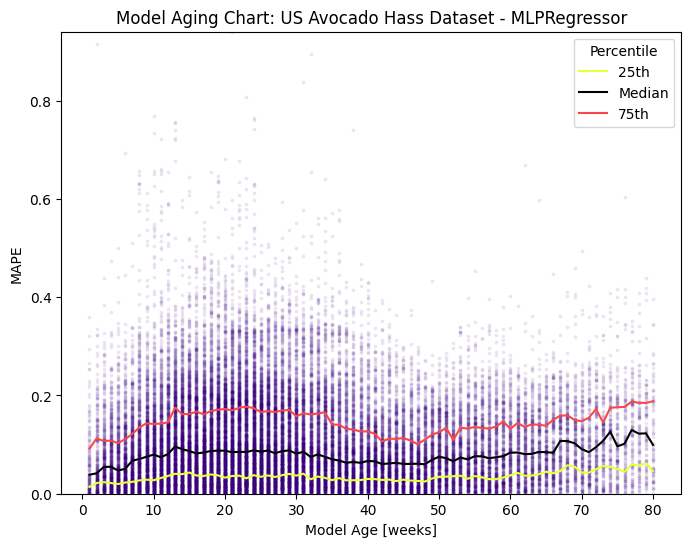

In [4]:
n_simulations = 3000
n_prod = 24
dataset = 'avocados'
freq='W'
models =['LGBMRegressor', 'ElasticNet', 'RandomForestRegressor', 'MLPRegressor']
plot_results()

In [26]:
d_errors_df = pd.read_parquet(f'../results/aging/{dataset}/aging_{dataset}_{models[0]}_{n_simulations}_simulations_{n_prod}_prod_{freq}.parquet')
d_errors_df['degradation'] = d_errors_df['error'] > 0.15


In [33]:
d_errors_df['degradation'].value_counts(normalize=True)

False    0.882614
True     0.117386
Name: degradation, dtype: float64

In [28]:
degradations_per_model = d_errors_df.groupby(['simulation_id'])[['degradation']].sum().reset_index()

In [29]:
degradations_per_model.degradation.sort_values()

1073     1
920      1
596      1
1602     1
551      1
        ..
132     39
1444    42
1663    44
2748    46
1454    48
Name: degradation, Length: 2770, dtype: int64

In [32]:
d_errors_df[d_errors_df['simulation_id']==1073]

,partition,simulation_id,timestamp,error,last_val_date,model_age,is_model_valid,error_rel,degradation
139596,train,1073,2016-02-14,0.000763,2017-04-30,-63.0,True,0.017027,False
139597,train,1073,2016-02-21,0.000167,2017-04-30,-62.0,True,0.003730,False
139598,train,1073,2016-02-28,0.000350,2017-04-30,-61.0,True,0.007802,False
139599,train,1073,2016-03-06,0.000130,2017-04-30,-60.0,True,0.002909,False
139600,train,1073,2016-03-13,0.000068,2017-04-30,-59.0,True,0.001520,False
...,...,...,...,...,...,...,...,...,...
139711,prod,1073,2017-11-12,0.029198,2017-04-30,28.0,True,0.651203,False
139712,prod,1073,2017-11-19,0.268457,2017-04-30,29.0,True,5.987456,True
139713,prod,1073,2017-11-26,0.139509,2017-04-30,30.0,True,3.111496,False
139714,prod,1073,2017-12-03,0.141324,2017-04-30,31.0,True,3.151975,False


In [31]:
import numpy as np
d_errors_df['degradation'] = d_errors_df['error'] > 0.15
degradations_per_model = d_errors_df.groupby(['simulation_id'])[['degradation']].sum().reset_index()
num_degradated_models = len(degradations_per_model[degradations_per_model['degradation'] > 0])

print(f"{num_degradated_models} out of {len(degradations_per_model)} models ({np.round(100 * num_degradated_models / len(degradations_per_model), 1)} %) degradaded")

2770 out of 2770 models (100.0 %) degradaded


In [13]:
d_errors_df['error'].quantile(0.75)

0.0870181993901876

In [8]:
len(d_errors_df[d_errors_df['error'] <= 0.1]) / len(d_errors_df) * 100

78.62159654758356

In [9]:
freq = 'M'
metric = mean_absolute_percentage_error

for model in models:
    errors_df = pd.read_parquet(f'../results/aging/{dataset}/aging_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod.parquet')
    d_errors_df = tdt.aggregate_errors_data(errors_df, metric=metric, freq=freq, only_valid_models=True)
    d_errors_df.to_parquet(f'../results/aging/{dataset}/aging_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod_{freq}.parquet')

In [41]:
freq = 'M'
d_errors_df = pd.read_parquet(f'../results/aging/{dataset}/aging_{dataset}_{models[0]}_{n_simulations}_simulations_{n_prod}_prod_{freq}.parquet')

In [42]:
d_errors_df

,partition,simulation_id,timestamp,error,last_val_date,model_age,is_model_valid,error_rel
0,train,0,2015-06-30,0.030116,2016-09-30,-15.047537,True,0.671673
1,train,0,2015-07-31,0.023567,2016-09-30,-14.029036,True,0.525630
2,train,0,2015-08-31,0.023581,2016-09-30,-13.010534,True,0.525925
3,train,0,2015-09-30,0.034685,2016-09-30,-12.024888,True,0.773597
4,train,0,2015-10-31,0.031170,2016-09-30,-11.006386,True,0.695196
...,...,...,...,...,...,...,...,...
98625,prod,2999,2016-12-31,0.064920,2016-08-31,4.008296,True,1.447913
98626,prod,2999,2017-01-31,0.211803,2016-08-31,5.026797,True,4.723880
98627,prod,2999,2017-02-28,0.061629,2016-08-31,5.946734,True,1.374530
98628,prod,2999,2017-03-31,0.094707,2016-08-31,6.965235,True,2.112275


In [57]:
data = d_errors_df[d_errors_df['partition'] == 'prod']
data.model_age = round(data.model_age).astype(int)
data = data[(data['model_age'] >= 0) & (data['model_age'] <= 20)]


/var/folders/yn/9gj_99ys1mz0_tkl2kvh5wd40000gn/T/ipykernel_2745/1444763648.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.model_age = round(data.model_age).astype(int)


Text(0.5, 1.0, 't')

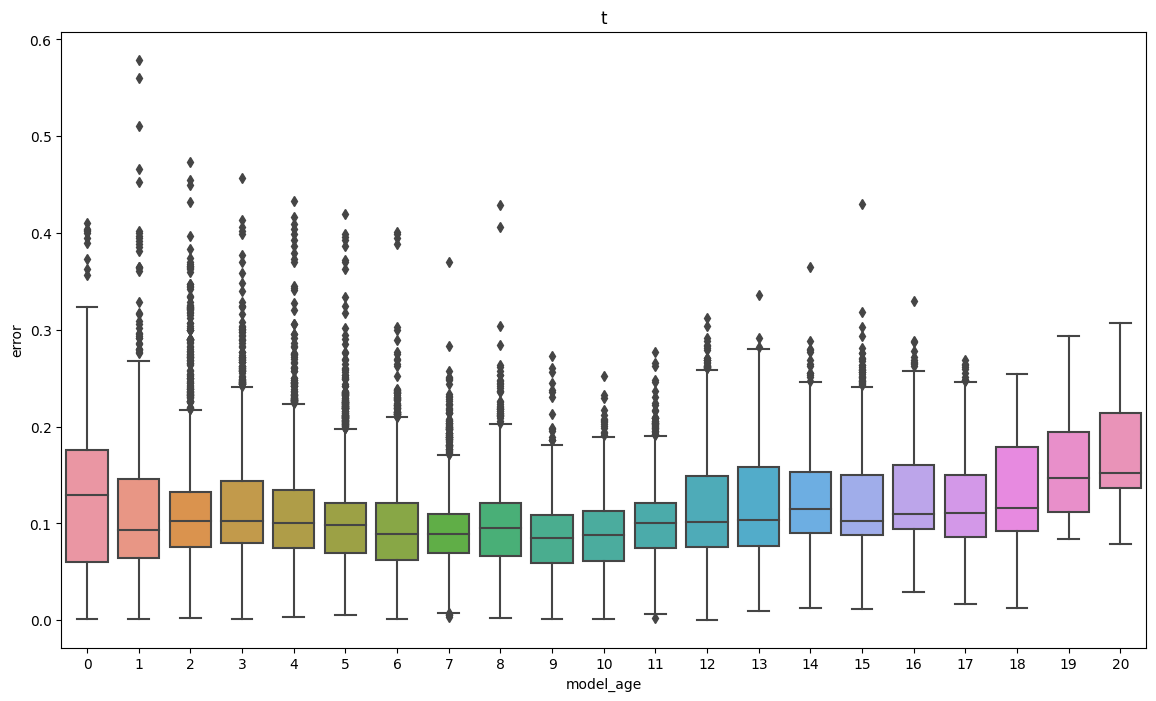

In [61]:
for model in models:
    data = d_errors_df[d_errors_df['partition'] == 'prod']
    data.model_age = round(data.model_age).astype(int)
    data = data[(data['model_age'] >= 0) & (data['model_age'] <= 20)]

fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data=data, x="model_age", y="error", ax=ax)
ax.set_title('Weekly error distribution: US Avocado Hass Dataset - Model')